In [77]:
%matplotlib inline

import re
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from __future__ import division
from math import ceil
from sklearn import linear_model
from sklearn.linear_model import Perceptron, PassiveAggressiveClassifier, SGDClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from collections import Counter
from nltk.corpus import stopwords
from pylab import plot, show, subplot, specgram, imshow, savefig

red = "#b92b27"
blue = "#272bb9"

In [4]:
working_dir = "C:\\Users\\The Hero Dood!\\Documents\\assignments\\project_week1\\data"
os.chdir(working_dir)

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
train_df.rename(columns = {"id":"test_id"}, inplace = True)

### Check for missing data in the training set

total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending = False)
missing_df = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_df

Total   Percent
question2         2  0.000005
is_duplicate      0  0.000000
question1         0  0.000000
qid2              0  0.000000
qid1              0  0.000000
test_id           0  0.000000

In [6]:
### Remove missing data and check again

train_df.dropna(inplace = True)

total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending = False)
missing_df = pd.concat([total, percent], axis = 1, keys = ["Total", "Percent"])
missing_df

Total  Percent
is_duplicate      0      0.0
question2         0      0.0
question1         0      0.0
qid2              0      0.0
qid1              0      0.0
test_id           0      0.0

In [7]:
qids = pd.Series(train_df["qid1"].tolist() + train_df["qid2"].tolist())
questions_df = pd.concat(
    [train_df[["qid1", "question1"]].rename(columns = {"qid1":"qid", "question1":"question"}),
     train_df[["qid2", "question2"]].rename(columns = {"qid2":"qid", "question2":"question"})]
)

In [8]:
print "Training Data\n"
print "Total number of question pairs: {}".format(len(train_df))
print "Total number of duplicate pairs: {} %".format(round(train_df["is_duplicate"].mean() * 100, 2))
print "Total number of unique questions: {}".format(len(np.unique(qids)))
print "Total number of questions that occur multiple times: {}".format(np.sum(qids.value_counts() > 1))

Training Data

Total number of question pairs: 404288
Total number of duplicate pairs: 36.92 %
Total number of unique questions: 537931
Total number of questions that occur multiple times: 111778


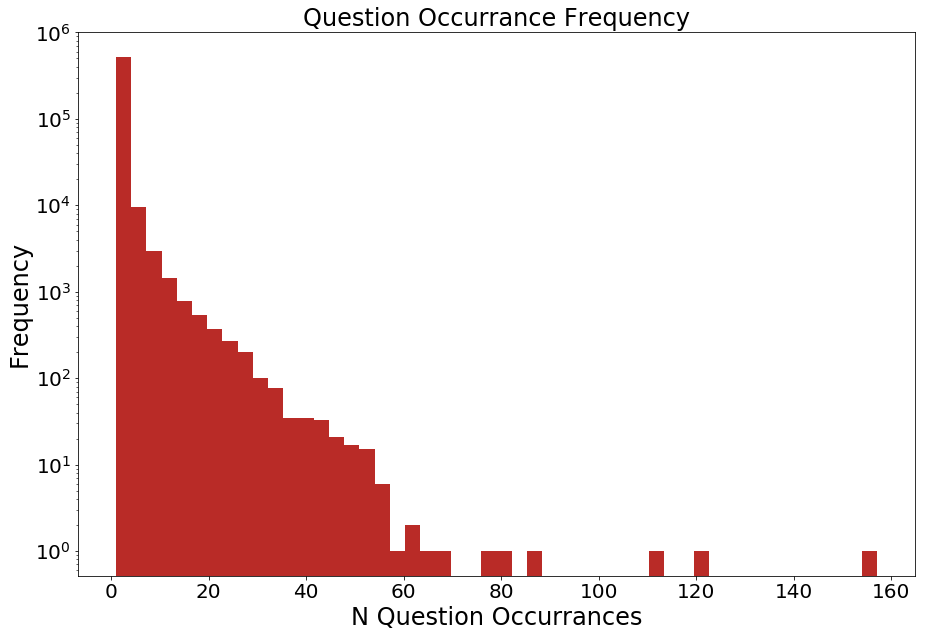

In [9]:
plt.figure(figsize=(15,10))
plt.hist(qids.value_counts(), bins = 50, log = True, color = red)
plt.title("Question Occurrance Frequency", fontsize = 24)
plt.xlabel("N Question Occurrances", fontsize = 24)
plt.xticks(fontsize = 20)
plt.ylabel("Frequency", fontsize = 24)
plt.yticks(fontsize = 20)
plt.savefig("quest_freq.png", dpi = 300)

In [10]:
questions_df["question"].value_counts().head()

What are the best ways to lose weight?                                             161
How can you look at someone's private Instagram account without following them?    120
How can I lose weight quickly?                                                     111
What's the easiest way to make money online?                                        88
Can you see who views your Instagram?                                               79
Name: question, dtype: int64

In [11]:
print questions_df["question"].str.lower().str.contains("lose weight").mean()
print questions_df["question"].str.lower().str.contains("lose weight").sum()

print "\n"

print questions_df["question"].str.lower().str.contains("weight loss").mean()
print questions_df["question"].str.lower().str.contains("weight loss").sum()

print "\n"

print questions_df["question"].str.lower().str.contains("losing weight").mean()
print questions_df["question"].str.lower().str.contains("losing weight").sum()

0.00389573769194
3150


0.000725967627038
587


0.00035494498971
287


In [12]:
print questions_df["question"].str.lower().str.contains("instagram").mean()
print questions_df["question"].str.lower().str.contains("instagram").sum()

0.00616639623239
4986


In [13]:
print questions_df["question"].str.lower().str.contains("make money").mean()
print questions_df["question"].str.lower().str.contains("make money").sum()

0.00432736069337
3499


In [14]:
print questions_df["question"].str.lower().str.contains("money").mean()
print questions_df["question"].str.lower().str.contains("money").sum()

0.0175864730093
14220


In [15]:
money = questions_df["question"].str.contains("money", case = False)
instagram = questions_df["question"].str.contains("instagram", case = False)
weight_loss = questions_df["question"].str.contains("lose weight", case = False) | questions_df["question"].str.contains("losing weight", case = False) | questions_df["question"].str.contains("weight loss", case = False)

money = pd.Series([money.mean(), money.sum()]).to_frame()
instagram = pd.Series([instagram.mean(), instagram.sum()]).to_frame()
weight_loss = pd.Series([weight_loss.mean(), weight_loss.sum()]).to_frame()

fig_table_df = pd.concat([money, instagram, weight_loss], axis = 1, keys = ["Money", "Instagram", "Weight Loss"])
fig_table_df = fig_table_df.transpose()
fig_table_df.columns = ["Percent", "Count"]
fig_table_df["Count"] = fig_table_df["Count"].astype("int")
fig_table_df["Percent"] = fig_table_df["Percent"] * 100
fig_table_df["Percent"] = fig_table_df["Percent"].round(1)
fig_table_df["Percent"] = fig_table_df["Percent"].astype("str") + " %"
fig_table_df

Percent  Count
Money       0   1.8 %  14220
Instagram   0   0.6 %   4986
Weight Loss 0   0.5 %   3956

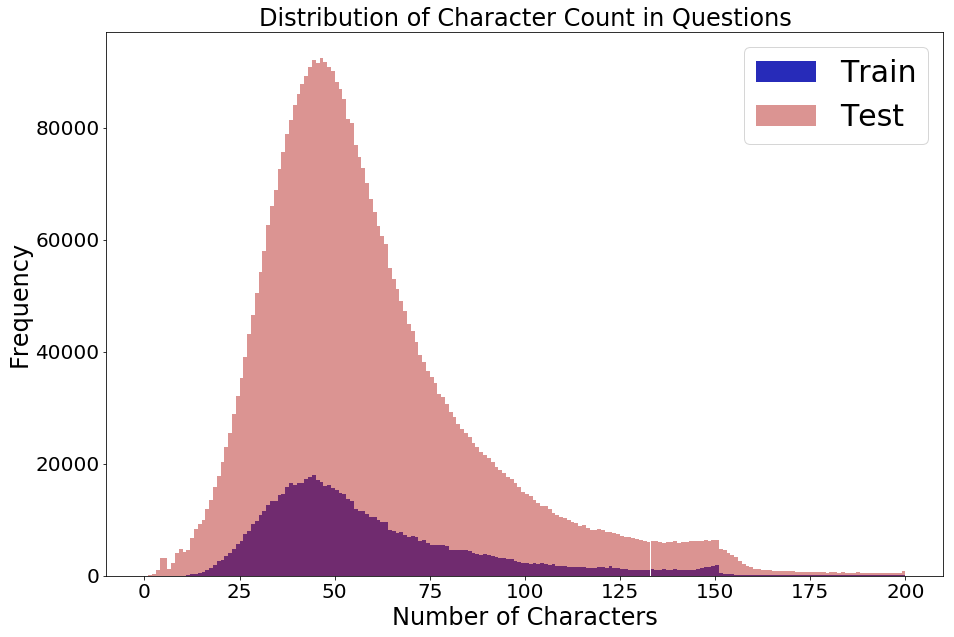

In [16]:
### Semantic duplicates model exploratory analysis

### Text analysis

train_quest = pd.Series(train_df["question1"].tolist() + train_df["question2"].tolist()).astype(str)
test_ques = pd.Series(test_df["question1"].tolist() + test_df["question2"].tolist()).astype(str)
train_dist = train_quest.apply(len)
test_dist = test_ques.apply(len)
plt.figure(figsize = (15,10))
plt.hist(train_dist, bins = 200, range = [0,200], label = 'Train', color = blue)
plt.hist(test_dist, bins = 200, range = [0,200], alpha = 0.5,  label = 'Test', color = red)
plt.xlabel("Number of Characters", fontsize = 24)
plt.xticks(fontsize = 20)
plt.ylabel("Frequency", fontsize = 24)
plt.yticks(fontsize = 20)
plt.legend(prop = {"size": 30})
plt.title("Distribution of Character Count in Questions", fontsize = 24)
plt.savefig("char_dist.png", dpi = 300)

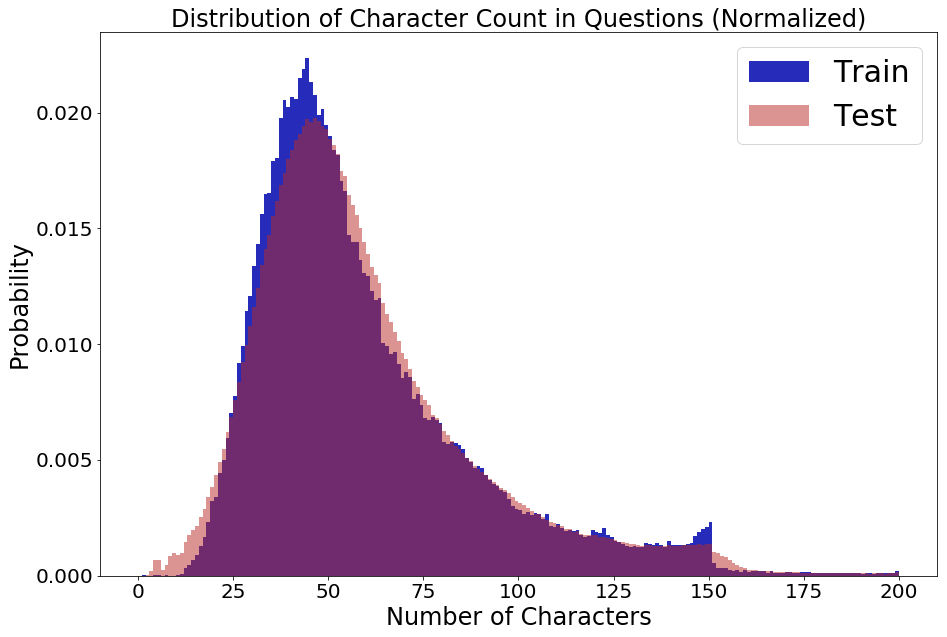

In [17]:
train_quest = pd.Series(train_df["question1"].tolist() + train_df["question2"].tolist()).astype(str)
test_ques = pd.Series(test_df["question1"].tolist() + test_df["question2"].tolist()).astype(str)
train_dist = train_quest.apply(len)
test_dist = test_ques.apply(len)
plt.figure(figsize = (15,10))
plt.hist(train_dist, bins = 200, range = [0,200], density = True, label = 'Train', color = blue)
plt.hist(test_dist, bins = 200, range = [0,200], density = True, alpha = 0.5,  label = 'Test', color = red)
plt.xlabel("Number of Characters", fontsize = 24)
plt.xticks(fontsize = 20)
plt.ylabel("Probability", fontsize = 24)
plt.yticks(fontsize = 20)
plt.legend(prop = {"size": 30})
plt.title("Distribution of Character Count in Questions (Normalized)", fontsize = 24)
plt.savefig("char_dist_norm.png", dpi = 300)

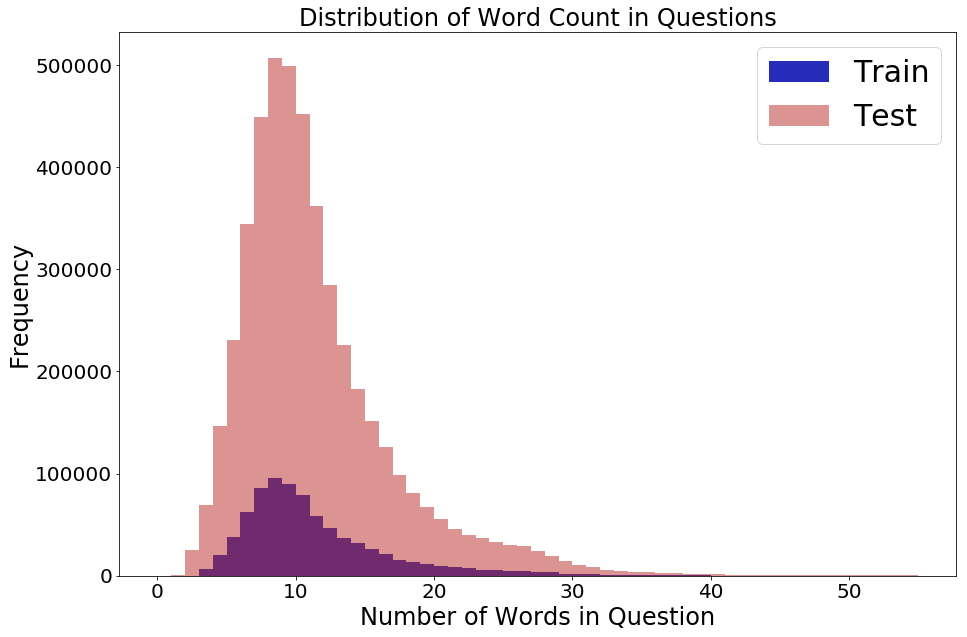

In [18]:
train_dist = train_quest.apply(lambda x: len(x.split(' ')))
test_dist = test_ques.apply(lambda x: len(x.split(' ')))
plt.figure(figsize = (15, 10))
plt.hist(train_dist, bins = 55, range = [0,55], label = 'Train', color = blue)
plt.hist(test_dist, bins = 55, range = [0,55], alpha = 0.5,  label = 'Test', color = red)
plt.xlabel("Number of Words in Question", fontsize = 24)
plt.xticks(fontsize = 20)
plt.ylabel("Frequency", fontsize = 24)
plt.yticks(fontsize = 20)
plt.legend(prop = {"size": 30})
plt.title("Distribution of Word Count in Questions", fontsize = 24)
plt.savefig("word_dist.png", dpi = 300)

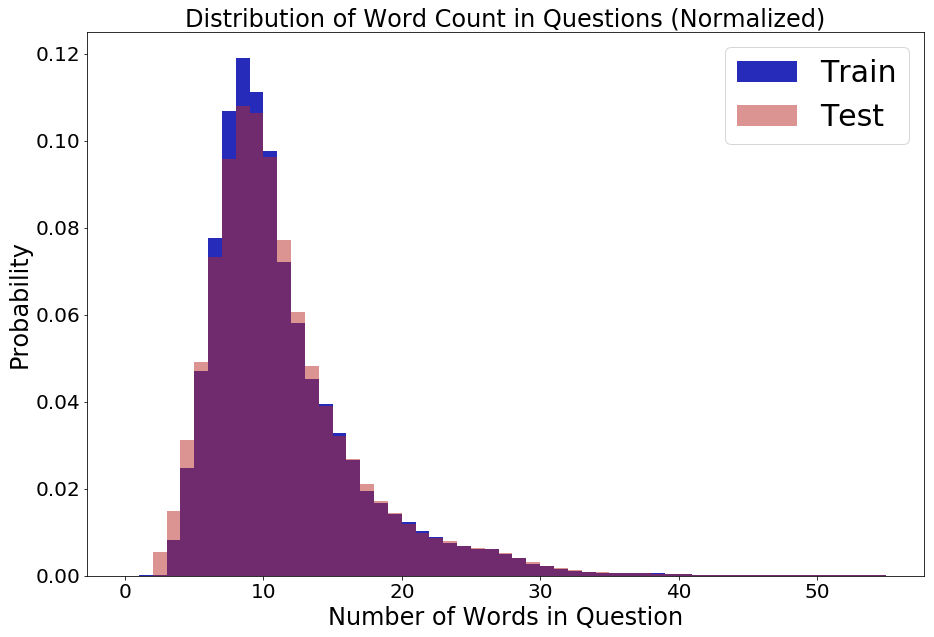

In [19]:
train_dist = train_quest.apply(lambda x: len(x.split(' ')))
test_dist = test_ques.apply(lambda x: len(x.split(' ')))
plt.figure(figsize = (15, 10))
plt.hist(train_dist, bins = 55, range = [0,55], density = True, label = 'Train', color = blue)
plt.hist(test_dist, bins = 55, range = [0,55], density = True, alpha = 0.5,  label = 'Test', color = red)
plt.xlabel("Number of Words in Question", fontsize = 24)
plt.xticks(fontsize = 20)
plt.ylabel("Probability", fontsize = 24)
plt.yticks(fontsize = 20)
plt.legend(prop = {"size": 30})
plt.title("Distribution of Word Count in Questions (Normalized)", fontsize = 24)
plt.savefig("word_dist_norm.png", dpi = 300)

In [20]:
### Semantic Analysis

quest_marks = np.mean(train_quest.apply(lambda x : "?" in x))
math_tag = np.mean(train_quest.apply(lambda x : "[math]" in x))
fullstop = np.mean(train_quest.apply(lambda x : "." in x))
capital_first = np.mean(train_quest.apply(lambda x : x[0].isupper()))
capital = np.mean(train_quest.apply(lambda x : max([y.isupper() for y  in x])))
numbers = np.mean(train_quest.apply(lambda x : max([y.isdigit() for y  in x])))

print "Questions with question_marks : {:.2f}%".format(quest_marks * 100)
print "Questions with math_tag : {:.2f}%".format(math_tag * 100)
print "Questions with fullstop : {:.2f}%".format(fullstop * 100)
print "Questions with capital first letter : {:.2f}%".format(capital_first * 100)
print "Questions with capital letters : {:.2f}%".format(capital * 100)
print "Questions with numbers : {:.2f}%".format(numbers * 100)

Questions with question_marks : 99.87%
Questions with math_tag : 0.12%
Questions with fullstop : 6.31%
Questions with capital first letter : 99.81%
Questions with capital letters : 99.95%
Questions with numbers : 11.83%


In [21]:
stops = set(stopwords.words("english"))

In [22]:
def word_match(row):
    q1words = {}
    q2words = {}
    
    for word in str(row["question1"]).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row["question2"]).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0

    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

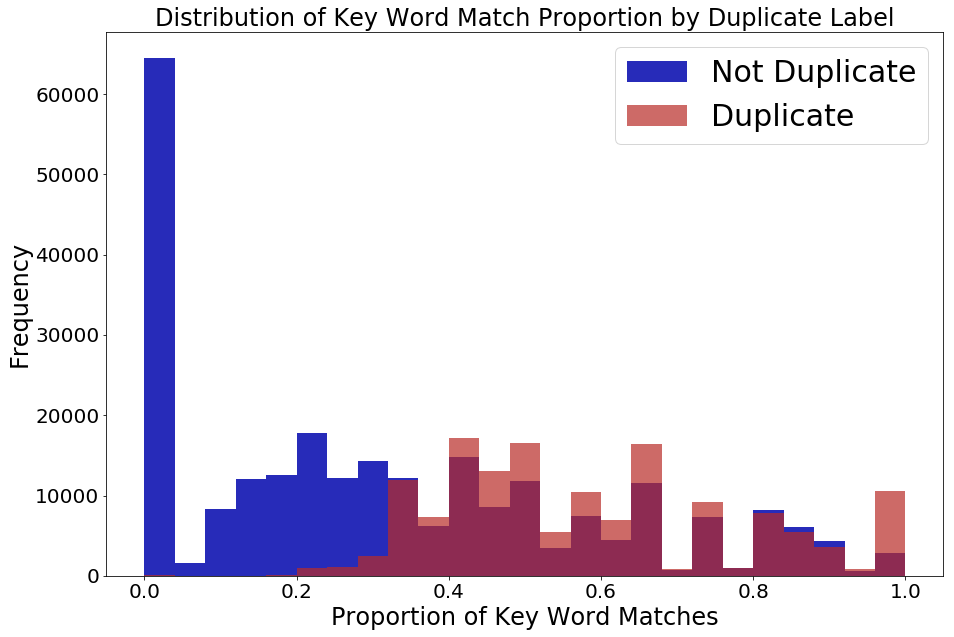

In [23]:
plt.figure(figsize = (15, 10))
train_word_match = train_df.apply(word_match, axis = 1, raw = True)
plt.hist(train_word_match[train_df["is_duplicate"] == 0], bins = 25, label = "Not Duplicate", color = blue)
plt.hist(train_word_match[train_df["is_duplicate"] == 1], bins = 25, alpha = 0.7, label = "Duplicate", color = red)
plt.xlabel("Proportion of Key Word Matches", fontsize = 24)
plt.xticks(fontsize = 20)
plt.ylabel("Frequency", fontsize = 24)
plt.yticks(fontsize = 20)
plt.legend(prop = {"size": 30})
plt.title("Distribution of Key Word Match Proportion by Duplicate Label", fontsize = 24)
plt.savefig("word_match_dist.png", dpi = 300)

In [60]:
### Logistic Regression Model

Bag = CountVectorizer(
    max_df = 0.999, min_df = 50, max_features = 300,
    analyzer = "char", ngram_range = (1,2), binary = True,
    lowercase = True, stop_words = "english"
    )
Bag.fit(pd.concat((train_df["question1"], train_df["question2"])).unique())

CountVectorizer(analyzer='char', binary=True, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.999, max_features=300, min_df=50,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [61]:
train_thresh = int(ceil(len(train_df) * 0.9))

question1 = Bag.transform(train_df.iloc[:train_thresh]["question1"])
question2 = Bag.transform(train_df.iloc[:train_thresh]["question2"])

test_question1 = Bag.transform(train_df.iloc[train_thresh:]["question1"])
test_question2 = Bag.transform(train_df.iloc[train_thresh:]["question2"])

In [62]:
X = -(question1 != question2).astype(int)
y = train_df.iloc[:train_thresh]["is_duplicate"].values

In [103]:
logisticRegressor = linear_model.LogisticRegression(
    C = 0.1, solver = "sag",
    class_weight={0: 1.30905513329, 1: 0.472008228977}
)

logisticRegressor.fit(X, y)

LogisticRegression(C=0.1, class_weight={0: 1.30905513329, 1: 0.472008228977},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False)

In [104]:
X_test = -(test_question1 != test_question2).astype(int)
y_test = train_df.iloc[train_thresh:]["is_duplicate"].values

y_pred = logisticRegressor.predict(X_test)
y_pred_prob = logisticRegressor.predict_proba(X_test)
y_score = logisticRegressor.score(X_test, y_test)

y_pred_prob0 = [i[0] for i in y_pred_prob]
y_pred_prob1 = [i[1] for i in y_pred_prob]

In [105]:
np.mean(y_pred == y_test)

0.67752547739190661

In [106]:
print y_score

0.677525477392


In [107]:
np.mean(cross_val_score(logisticRegressor, X, y, scoring="precision"))

0.81375019875199683

In [108]:
np.mean(cross_val_score(logisticRegressor, X, y, scoring="recall"))

0.10067690185779123

In [67]:
roc_curve(y_test, y_pred_prob1)

(array([  0.00000000e+00,   0.00000000e+00,   3.79650721e-05, ...,
          9.62604404e-01,   9.62604404e-01,   1.00000000e+00]),
 array([  7.09823964e-05,   3.54911982e-04,   3.54911982e-04, ...,
          9.99929018e-01,   1.00000000e+00,   1.00000000e+00]),
 array([  9.00019344e-01,   8.84270029e-01,   8.78811655e-01, ...,
          1.18020311e-02,   1.18017177e-02,   5.59578156e-05]))

In [68]:
roc_auc_score(y_test, y_pred)

0.68442675328135927

In [69]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

0     1
0  20814  5526
1   5936  8152

In [70]:
thresholds = np.linspace(0,1,1000).tolist()

scores = []

for i in thresholds:
    test_thresh = [i] * len(y_pred_prob1)
    test_thresh_pred = [(y_pred_prob1[i] >= test_thresh[i]).astype(int) for i in range(len(y_pred_prob1))]
    
    sc = np.mean(y_test == test_thresh_pred)
    
    scores.append(sc)

In [71]:
max(scores)

0.71920451172454736

In [72]:
thresholds[np.argmax(scores)]

0.5555555555555556

In [73]:
plt.figure(figsize = (15,10))
plt.plot(thresholds, scores, color = red, linewidth = 4)
plt.xlabel("Decision Probability Threshold", fontsize = 24)
plt.xticks(fontsize = 20)
plt.ylabel("Accuracy Score", fontsize = 24)
plt.yticks(fontsize = 20)
plt.title("Finding the Optimal Probability Threshold", fontsize = 24)
plt.savefig("thresh_plot.png", dpi = 300)

In [74]:
opt_thresh = [thresholds[np.argmax(scores)]] * len(y_pred_prob1)
y_pred_final = np.array([y_pred_prob1[i] >= opt_thresh[i] for i in xrange(len(y_pred_prob1))]).astype(int)

In [75]:
pd.DataFrame(confusion_matrix(y_test, y_pred_final))

0     1
0  22361  3979
1   7373  6715

In [38]:
total = test_df.isnull().sum().sort_values(ascending = False)
percent = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending = False)
missing_df = pd.concat([total, percent], axis = 1, keys = ["Total", "Percent"])
missing_df

Total       Percent
question2      4  1.705178e-06
question1      2  8.525891e-07
test_id        0  0.000000e+00

In [39]:
test_df.dropna(inplace = True)

total = test_df.isnull().sum().sort_values(ascending = False)
percent = (test_df.isnull().sum()/test_df.isnull().count()).sort_values(ascending = False)
missing_df = pd.concat([total, percent], axis = 1, keys = ["Total", "Percent"])
missing_df

Total  Percent
question2      0      0.0
question1      0      0.0
test_id        0      0.0

In [40]:
def label_duplicates(df, threshold):
    question1 = Bag.transform(df["question1"])
    question2 = Bag.transform(df["question2"])
    
    X = -(question1 != question2).astype(int)
    
    is_duplicate_prob = logisticRegressor.predict_proba(X)
    is_duplicate_prob = [i[1] for i in is_duplicate_prob]
    
    vthresh = [threshold] * len(is_duplicate_prob)
    is_duplicate = np.array([is_duplicate_prob[i] >= vthresh[i] for i in xrange(len(is_duplicate_prob))]).astype(int)
    
    return is_duplicate


test_df["is_duplicate"] = label_duplicates(test_df, opt_thresh[0])

In [41]:
test_df.head()

test_id                                          question1  \
0        0  How does the Surface Pro himself 4 compare wit...   
1        1  Should I have a hair transplant at age 24? How...   
2        2  What but is the best way to send money from Ch...   
3        3                        Which food not emulsifiers?   
4        4                   How "aberystwyth" start reading?   

                                           question2  is_duplicate  
0  Why did Microsoft choose core m3 and not core ...             0  
1        How much cost does hair transplant require?             0  
2                      What you send money to China?             0  
3                                  What foods fibre?             0  
4                     How their can I start reading?             1

In [42]:
test_df.to_csv("model_output.csv")

In [ ]:
#model_ouput_df = pd.read_csv("model_output.csv")

In [ ]:
LinearDiscriminantAnalysis(solver = "sag")

In [ ]:
def x_val(data_frame, split = 0.9, n_times = 10):
    
    x_val_scores = []
    
    for i in xrange(n_times):
        train_split = int(ceil(len(data_frame) * split))
        
        question1 = Bag.transform(data_frame.iloc[:train_split]["question1"])
        question2 = Bag.transform(data_frame.iloc[:train_split]["question2"])
        
        test_question1 = Bag.transform(data_frame.iloc[train_split:]["question1"])
        test_question2 = Bag.transform(data_frame.iloc[train_split:]["question2"])
        
        X_train = -(question1 != question2).astype(int)
        y_train = data_frame.iloc[:train_split]["is_duplicate"].values
        
        logisticRegressor = linear_model.LogisticRegression(
            C = 0.1, solver = "sag",
            class_weight = {1: 0.472008228977, 0: 1.30905513329}
            )
        
        logisticRegressor.fit(X_train, y_train)
        
        X_test = -(test_question1 != test_question2).astype(int)
        y_test = data_frame.iloc[train_split:]["is_duplicate"].values
        
        y_score = logisticRegressor.score(X_test, y_test)
        
        x_val_scores.append(y_score)
        
    return x_val_scores

x_val_sc = x_val(train_df)

np.mean(x_val_sc)

In [ ]:
x_val_sc

In [94]:
# Implementation from scratch

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def j_scale(s1, s2):
    s1 = set(s1.split()).difference(stops)
    s2 = set(s2.split()).difference(stops)
    
    j = (len(s1.intersection(s2))/len(s1.union(s2))) - (len(s1.union(s2).difference(s1.intersection(s2)))/len(s1.union(s2)))
    
    return j

train_df["j_scale"] = [j_scale(train_df.iloc[i]["question1"], train_df.iloc[i]["question2"]) for i in range(len(train_df))]
train_df["sigmoid"] = [sigmoid(x) for x in train_df["j_scale"]]

is_duplicate_pred = []

for i in range(len(train_df)):
    if train_df.iloc[i]["sigmoid"] > 0.50:
        is_duplicate_pred.append(1)
    else:
        is_duplicate_pred.append(0)

train_df["is_duplicate_pred"] = is_duplicate_pred        

np.mean(train_df["is_duplicate"] == train_df["is_duplicate_pred"])

0.64854757004907393

In [98]:
pd.DataFrame(confusion_matrix(train_df["is_duplicate"], train_df["is_duplicate_pred"]))

0      1
0  221621  33404
1  108684  40579

In [100]:
p = 40579 / (40579 + 33404)
p

0.5484908695240799

In [102]:
r = 40579 / (40579 + 108684)
r

0.27186241734388294